# Introduction

Data from the mobile game, Cookie Cats, will be analyzed to see if changing an aspect of the game would be beneficial in terms of increasing retention rates.

Here's the launch video on YouTube:
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>

Players gain levels for going through the game and will face gates at certain levels that will prevent them from playing more until either a set time has passed or they make an in-game purchase. These gates are in place in the hopes of giving players a break from the game so that they can further enjoy the game longer. Here's what the gates look like: </p>

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

The question is, if we set the gate to be at level 40 instead of level 30, how will that affect retention rates (1-day and 7-day)? AB testing with Bayesian statistics will be performed to determine which method has retention rates.

The original data is provided by Rasmus Bååth on his project titled ["Mobile Games A/B Testing with Cookie Cats" on datacamp.com](https://www.datacamp.com/projects/184). Revisions to his approach will be explored here using the Pymc3 library.

## Import libraries

In [1]:
# Math & data
import numpy as np
import pandas as pd

# Stats
import pymc3 as pm
import scipy.stats as stats

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

## Load data

In [2]:
filepath = 'datasets/cookie_cats.csv'

cats_df = pd.read_csv(filepath)
cats_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Feature info:

__1. userid__: Unique ID of player

__2. version__: Version of the game that the player sees (gate at level 30 or level 40)

__3. sum_gamerounds__: number of rounds played

__4. retention_1__: Did the player play the game again after 1 day?

__5. retention_7__: Did the player play the game again after 7 days?

## How many players do we have in the gate_30 and gate_40 groups?

In [3]:
cats_df.groupby(by='version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


It looks like we have around 45,000 players per group. It's good to have an even amount of players in each group to have distributions that compare countwise, but even if the counts were uneven, Bayesian methodology can account for it!

## Distribution of players by the number of rounds played

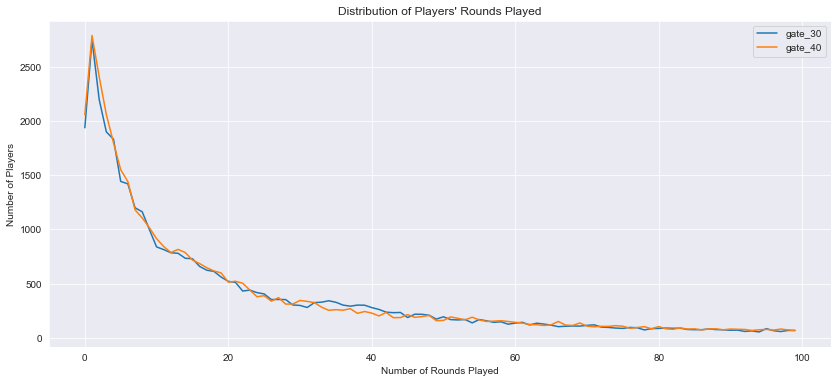

In [4]:
gate_30_gamerounds = cats_df.groupby(by=['version', 'sum_gamerounds']).count()['userid']['gate_30']
gate_40_gamerounds = cats_df.groupby(by=['version', 'sum_gamerounds']).count()['userid']['gate_40']

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(gate_30_gamerounds[:100], label='gate_30')
ax.plot(gate_40_gamerounds[:100], label='gate_40')
ax.set_title("Distribution of Players' Rounds Played")
ax.set_xlabel('Number of Rounds Played')
ax.set_ylabel('Number of Players')
ax.legend();

It is typical for mobile games to have the most of their players play less than other players. It's interesting to note that around 2000 players in each group have downloaded Cookie Cats without playing a single round.

## Looking at overall retention rates

In [5]:
print(f"Day 1 retention rates: { round(len(cats_df[ cats_df['retention_1']==True ]) / len(cats_df), 3) }")
print(f"Day 7 retention rates: { round(len(cats_df[ cats_df['retention_7']==True ]) / len(cats_df), 3) }")

Day 1 retention rates: 0.445
Day 7 retention rates: 0.186


# AB Testing

## Investigating day 1 retention

In [6]:
# Store day 1 retentions (1 for true, 0 for false)
gate_30_observations = cats_df[ cats_df['version']=='gate_30' ]['retention_1'].map({False:0, True:1})
gate_40_observations = cats_df[ cats_df['version']=='gate_40' ]['retention_1'].map({False:0, True:1})

# Setup Pymc3 model
with pm.Model() as model:
    # Use uniorm priors for both groups as to be unbiased
    p_30 = pm.Uniform('p_30', 0, 1)
    p_40 = pm.Uniform('p_40', 0, 1)
    
    # Define the eterministic delta function. This is our unknown of interest that will measure the differences in probability between having the gate at level 30 or level 40
    delta = pm.Deterministic('delta', p_30 - p_40)
    
    # Define our day 1 retention observations for both groups as bernoulli distributions
    obs_30 = pm.Bernoulli('obs_30', p_30, observed=gate_30_observations)
    obs_40 = pm.Bernoulli('obs_40', p_40, observed=gate_40_observations)
    
    # Run MCMC which samples 20,000 data points to create the posterior distribution for both p_30 & p_40
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, cores=1, chains=1)
    burned_trace = trace[1000:]

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [p_40]
>Metropolis: [p_30]
100%|██████████| 20500/20500 [00:39<00:00, 524.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Plot the posterior distributions for p_30, p_40, and delta

In [7]:
p_30_samples = burned_trace['p_30']
p_40_samples = burned_trace['p_40']
delta_samples = burned_trace['delta']

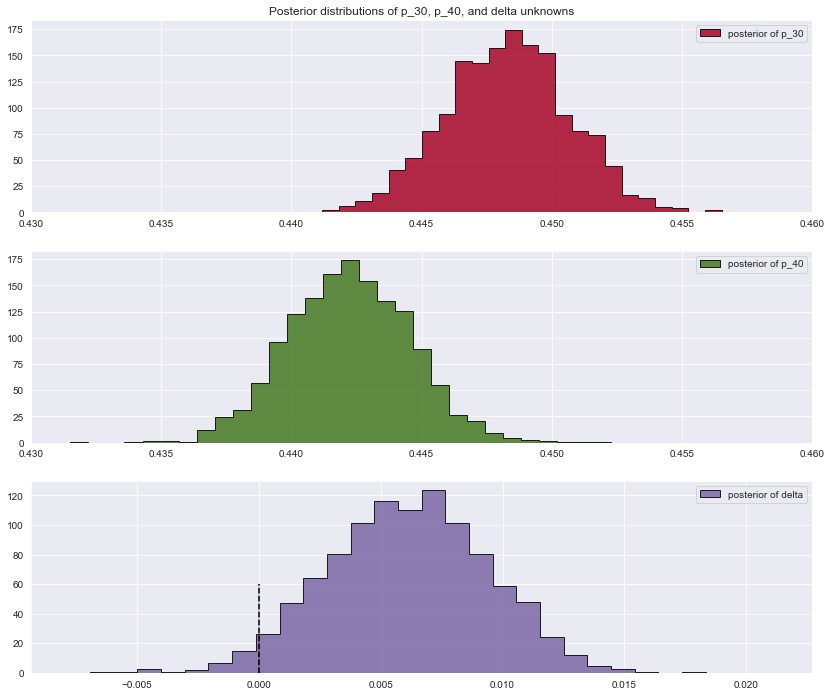

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12))

# Plot posterior distribution of p_30
ax[0].hist(p_30_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of p_30", color="#A60628", density=True, edgecolor='black')
ax[0].set_xlim(0.430, 0.460)
ax[0].set_title("Posterior distributions of p_30, p_40, and delta unknowns")
ax[0].legend(loc="upper right")

# Plot posterior distibution of p_40
ax[1].hist(p_40_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of p_40", color="#467821", density=True, edgecolor='black')
ax[1].set_xlim(0.430, 0.460)
ax[1].legend(loc="upper right")

# Plot posterior distribution of the difference of p_30 and p_40
ax[2].hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of delta", color="#7A68A6", density=True, edgecolor='black')
ax[2].vlines(0, 0, 60, linestyle="--")
ax[2].vlines(0, 0, 60, color="black", alpha=0.2)
ax[2].legend(loc="upper right");

In [9]:
print(f'Probability gate at level 30 is WORSE than level 40: {round(np.mean(delta_samples < 0) * 100, 2) }%')
print(f'Probability gate at level 30 is BETTER than level 40: {round(np.mean(delta_samples > 0) * 100, 2) }%')

Probability gate at level 30 is WORSE than level 40: 2.94%
Probability gate at level 30 is BETTER than level 40: 97.06%


## How confident can we be regarding the true probabilities of the retention rates?

C:\Users\moogl\Anaconda3\lib\site-packages\arviz\data\base.py:123: SyntaxWarning: More chains (19000) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


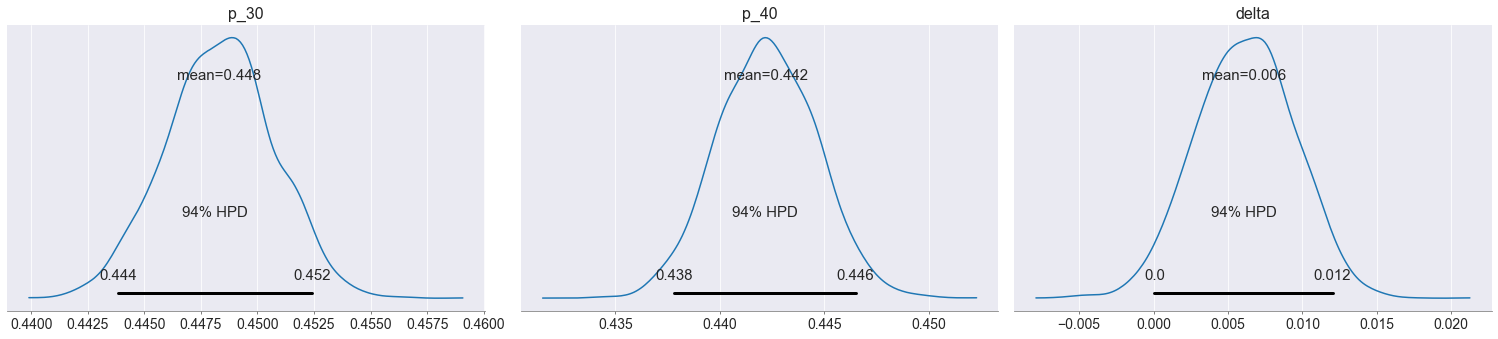

In [10]:
pm.plots.plot_posterior(data=burned_trace, round_to=3, kde_plot=False);

There is a 94% chance that the true retention rates for gates at level 30 and 40 are between certain values. This range is implicated by the horizontal bar denoting the 94% HPD, which is the _highest priority density_ interval. This can also be interpretated as a 94% chance that the variable lies in this interval. The wider the bar, the higher the uncertainty. This interval is important for reporting purposes since we can be highly confident that the true value is within this.

## Investigating day 7 retention

In [11]:
# Store day 7 retentions (1 for true, 0 for false)
gate_30_observations = cats_df[ cats_df['version']=='gate_30' ]['retention_7'].map({False:0, True:1})
gate_40_observations = cats_df[ cats_df['version']=='gate_40' ]['retention_7'].map({False:0, True:1})

# Setup Pymc3 model
with pm.Model() as model:
    # Use uniorm priors for both groups as to be unbiased
    p_30 = pm.Uniform('p_30', 0, 1)
    p_40 = pm.Uniform('p_40', 0, 1)
    
    # Define the eterministic delta function. This is our unknown of interest that will measure the differences in probability between having the gate at level 30 or level 40
    delta = pm.Deterministic('delta', p_30 - p_40)
    
    # Define our day 1 retention observations for both groups as bernoulli distributions
    obs_30 = pm.Bernoulli('obs_30', p_30, observed=gate_30_observations)
    obs_40 = pm.Bernoulli('obs_40', p_40, observed=gate_40_observations)
    
    # Run MCMC which samples 20,000 data points to create the posterior distribution for both p_30 & p_40
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, cores=1, chains=1)
    burned_trace = trace[1000:]

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [p_40]
>Metropolis: [p_30]
100%|██████████| 20500/20500 [00:28<00:00, 729.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Plot the posterior distributions for p_30, p_40, and delta

In [12]:
p_30_samples = burned_trace['p_30']
p_40_samples = burned_trace['p_40']
delta_samples = burned_trace['delta']

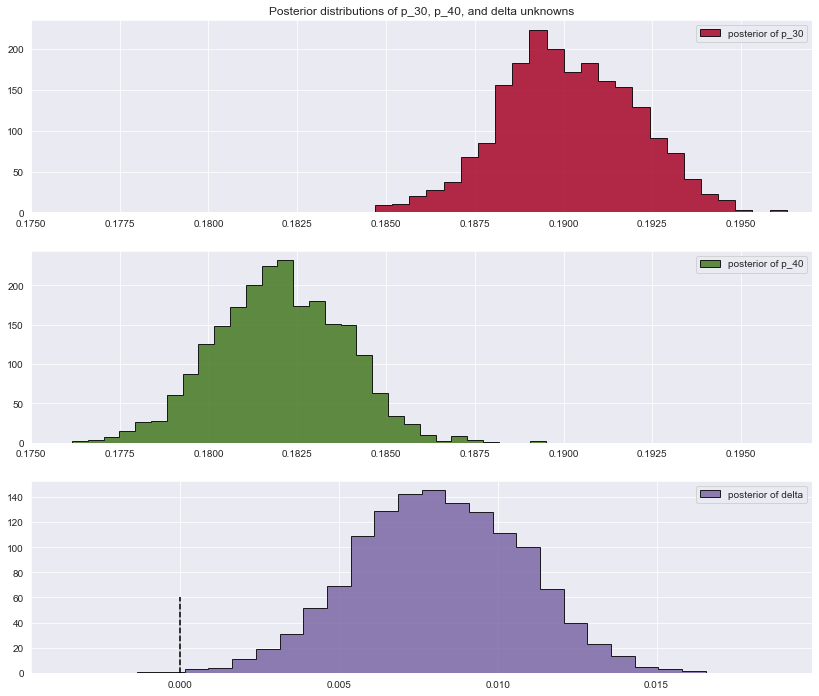

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12))

# Plot posterior distribution of p_30
ax[0].hist(p_30_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of p_30", color="#A60628", density=True, edgecolor='black')
ax[0].set_xlim(0.175, 0.197)
ax[0].set_title("Posterior distributions of p_30, p_40, and delta unknowns")
ax[0].legend(loc="upper right")

# Plot posterior distibution of p_40
ax[1].hist(p_40_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of p_40", color="#467821", density=True, edgecolor='black')
ax[1].set_xlim(0.175, 0.197)
ax[1].legend(loc="upper right")

# Plot posterior distribution of the difference of p_30 and p_40
ax[2].hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of delta", color="#7A68A6", density=True, edgecolor='black')
ax[2].vlines(0, 0, 60, linestyle="--")
ax[2].vlines(0, 0, 60, color="black", alpha=0.2)
ax[2].legend(loc="upper right");

In [14]:
print(f'Probability gate at level 30 is WORSE than level 40: {round(np.mean(delta_samples < 0) * 100, 2) }%')
print(f'Probability gate at level 30 is BETTER than level 40: {round(np.mean(delta_samples > 0) * 100, 2) }%')

Probability gate at level 30 is WORSE than level 40: 0.08%
Probability gate at level 30 is BETTER than level 40: 99.92%


## How confident can we be regarding the true probabilities of the retention rates?

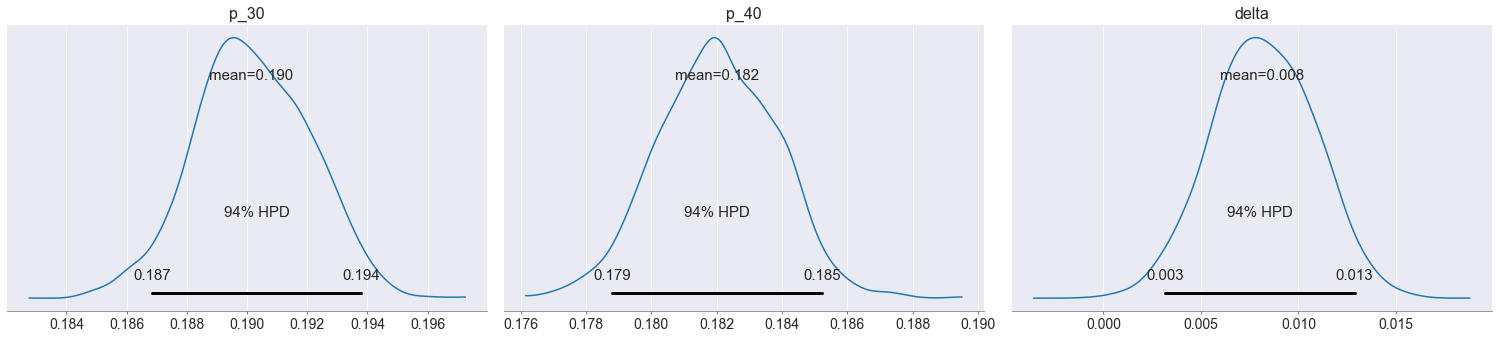

In [18]:
pm.plots.plot_posterior(data=burned_trace, round_to=3);

# Conclusion

For both day 1 and 7 retention rates, having the gate at level 30 instead of 40 looks to be the clear choice to make here!